<a href="https://colab.research.google.com/github/takanto/FER2013/blob/main/FER2013_ViT_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**FER2013 ViT Implementation**

The GoogleColab used to pretrain ViT.


###**Importing libraries**

In [ ]:
! pip install pillow-heif
! pip install opendatasets
!pip install -U -q "tf-models-official"

import tensorflow as tf
import pandas as pd
import os
import opendatasets as od
from matplotlib import pyplot
from math import sqrt
import numpy as np
import scipy.misc
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2DTranspose, Dropout, Reshape, LeakyReLU, Conv2D, concatenate
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from scipy.stats import uniform
from matplotlib.pylab import rcParams
from PIL import Image
import itertools
import glob
import random
from pillow_heif import register_heif_opener
from skimage import io
import pprint
import tempfile
from IPython import display
import tensorflow_datasets as tfds
import tensorflow_models as tfm
# These are not in the tfm public API for v2.9. They will be available in v2.10
from official.vision.serving import export_saved_model_lib
import official.core.train_lib
%matplotlib inline

###**Loading Dataset**

In [ ]:
dataset = 'https://www.kaggle.com/datasets/deadskull7/fer2013'

od.download(dataset)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: takanto
Your Kaggle Key: ··········


100%|██████████| 96.6M/96.6M [00:01<00:00, 86.7MB/s]


In [ ]:
df = pd.read_csv('fer2013/fer2013.csv')

df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


###**Data preprocessing**

In [ ]:
X = np.array(list(map(str.split, df.pixels)), np.float32)
X = X / 255.0

In [ ]:
X = X.reshape(X.shape[0], 48, 48, 1)
X = np.stack((X,)*3, axis=-1)
X = X.reshape(X.shape[0], 48, 48, 3)

In [ ]:
y = np.array(df.emotion)
enc = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
y = y.reshape(-1, 1)
y = enc.fit_transform(y)

###**Exploratory data analysis**

Then, the function below can plot 9 randomely selected images in np.array. The data can deal with plotting any dimenstion and color map.

In [ ]:
def plot_rand_imgs(data, img_size, pred='nan', actual='nan'):
  """
  choose 9 random images stored in numpy array and plot them

  Parameters
  -----------------
  data (numpy array): numpy array containing images
  img_size (tuple): image size of images

  Returns
  -----------------
  None (show plot)
  """
  # images selected
  random_ids = np.random.choice(data.shape[0], 9)

  # for every image, plot it as a subplot
  j = 0
  fig = plt.figure()
  for i in random_ids:
    ax = plt.subplot(330 + 1 + j)
    ax.axis('off')
    # if there is a list of predictions, display it as title
    if type(actual) != str:
      title = f'actual: {actual[i]}'
      if type(pred) != str:
        title += f', pred: {pred[i]}'
      ax.title.set_text(title)
    # if RGB is stored, convert it to RGB
    img = data[i]
    if img_size[2]==3:
      ax.imshow(cv2.cvtColor(img.reshape(img_size[0], img_size[1], 3), cv2.COLOR_BGR2RGB))
    # if grayscale is stored, plot it with gray color map
    elif img_size[2]==1:
      ax.imshow(img.reshape(img_size[0], img_size[1], 1), plt.get_cmap('gray'))

    j += 1

  plt.axis('off')
  plt.show()

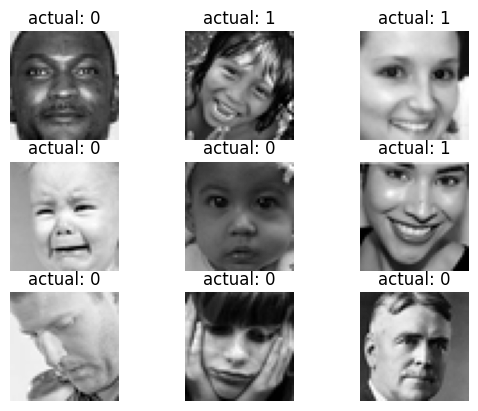

In [ ]:
plot_rand_imgs(X, img_size=(48,48,3), actual=y)

From the plots above, it can be confirmed that the data augumentations are performed correctly and the labels are correctly assigned. the function below generates dataframe of unique values and their frequency in a numpy array. It is used to see the frequency of drunk and sober face in both datasets.

###**Overall pipeline**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test))

ds_info_train = tfds.core.DatasetInfo(
    name='fer2013_train',
    version='1.0.0',  # Update with your dataset version
    description='fer2013 custom training dataset',
    features=tfds.features.FeaturesDict({
        'images': tfds.features.Tensor(shape=(X_train.shape[0],48,48,3), dtype=tf.float32),
        'labels': tfds.features.ClassLabel(names=['angry','disgust','fear','happy','sad','surprise','neutral']),
    }),
    # Additional metadata...
)

ds_info_test = tfds.core.DatasetInfo(
    name='fer2013_test',
    version='1.0.0',  # Update with your dataset version
    description='fer2013 custom testing dataset',
    features=tfds.features.FeaturesDict({
        'images': tfds.features.Tensor(shape=(X_test.shape[0],48,48,3), dtype=tf.float32),
        'labels': tfds.features.ClassLabel(names=['angry','disgust','fear','happy','sad','surprise','neutral']),
    }),
    # Additional metadata...
)

tfds.core.registered.register(train_ds, ds_info_train)
tfds.core.registered.register(test_ds, ds_info_test)

'''
# Register the datasets (optional)
tfds.core.DatasetBuilder(name="fer2013_train", data_files=["train.tfrecord"])
tfds.core.DatasetBuilder(name="fer2013_test", data_files=["test.tfrecord"])

# Save the datasets to TFRecord files (optional)
tf.data.experimental.TFRecordWriter("train.tfrecord").write(train_ds)
tf.data.experimental.TFRecordWriter("test.tfrecord").write(test_ds)

# Load the datasets from TFRecord files (optional)
train_tfds = tfds.load("custom_dataset_train", split="train")
test_tfds = tfds.load("custom_dataset_test", split="test")
ds,ds_info = tfds.load('fer2013', with_info=True)

ds_info
'''

In [ ]:
exp_config = tfm.core.exp_factory.get_exp_config('vit_imagenet_finetune')

In [ ]:
# Configure model
exp_config.task.model.num_classes = 7
exp_config.task.model.input_size = [48,48,3]

# Configure training and testing data
batch_size = 128

exp_config.task.train_data.input_path = ''
exp_config.task.train_data.tfds_name = 'fer2013_train'
exp_config.task.train_data.tfds_split = 'train'
exp_config.task.train_data.global_batch_size = batch_size

exp_config.task.validation_data.input_path = ''
exp_config.task.validation_data.tfds_name = 'fer2013_test'
exp_config.task.validation_data.tfds_split = 'test'
exp_config.task.validation_data.global_batch_size = batch_size

###**Model Training**

In [ ]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if 'GPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'GPU'
elif 'TPU' in ''.join(logical_device_names):
  print('This may be broken in Colab.')
  device = 'TPU'
else:
  print('Running on CPU is slow, so only train for a few steps.')
  device = 'CPU'

if device=='CPU':
  train_steps = 20
  exp_config.trainer.steps_per_loop = 5
else:
  train_steps=5000
  exp_config.trainer.steps_per_loop = 100

exp_config.trainer.summary_interval = 100
exp_config.trainer.checkpoint_interval = train_steps
exp_config.trainer.validation_interval = 1000
exp_config.trainer.validation_steps =  ds_info.splits['test'].num_examples // batch_size
exp_config.trainer.train_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.type = 'cosine'
exp_config.trainer.optimizer_config.learning_rate.cosine.decay_steps = train_steps
exp_config.trainer.optimizer_config.learning_rate.cosine.initial_learning_rate = 0.1
exp_config.trainer.optimizer_config.warmup.linear.warmup_steps = 100

In [ ]:
pprint.pprint(exp_config.as_dict())

display.Javascript("google.colab.output.setIframeHeight('300px');")

In [ ]:
logical_device_names = [logical_device.name for logical_device in tf.config.list_logical_devices()]

if exp_config.runtime.mixed_precision_dtype == tf.float16:
    tf.keras.mixed_precision.set_global_policy('mixed_float16')

if 'GPU' in ''.join(logical_device_names):
  distribution_strategy = tf.distribute.MirroredStrategy()
elif 'TPU' in ''.join(logical_device_names):
  tf.tpu.experimental.initialize_tpu_system()
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='/device:TPU_SYSTEM:0')
  distribution_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
  print('Warning: this will be really slow.')
  distribution_strategy = tf.distribute.OneDeviceStrategy(logical_device_names[0])

In [ ]:
with distribution_strategy.scope():
  model_dir = tempfile.mkdtemp()
  task = tfm.core.task_factory.get_task(exp_config.task, logging_dir=model_dir)

In [ ]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  print()
  print(f'images.shape: {str(images.shape):16}  images.dtype: {images.dtype!r}')
  print(f'labels.shape: {str(labels.shape):16}  labels.dtype: {labels.dtype!r}')

In [ ]:
model, eval_logs = tfm.core.train_lib.run_experiment(
    distribution_strategy=distribution_strategy,
    task=task,
    mode='train_and_eval',
    params=exp_config,
    model_dir=model_dir,
    run_post_eval=True)

###**Model Evaluation**

In [ ]:
for key, value in eval_logs.items():
    if isinstance(value, tf.Tensor):
      value = value.numpy()
    print(f'{key:20}: {value:.3f}')

In [ ]:
def show_batch(images, labels, predictions=None):
  plt.figure(figsize=(10, 10))
  min = images.numpy().min()
  max = images.numpy().max()
  delta = max - min

  for i in range(12):
    plt.subplot(6, 6, i + 1)
    plt.imshow((images[i]-min) / delta)
    if predictions is None:
      plt.title(label_info.int2str(labels[i]))
    else:
      if labels[i] == predictions[i]:
        color = 'g'
      else:
        color = 'r'
      plt.title(label_info.int2str(predictions[i]), color=color)
    plt.axis("off")

In [ ]:
for images, labels in task.build_inputs(exp_config.task.train_data).take(1):
  predictions = model.predict(images)
  predictions = tf.argmax(predictions, axis=-1)

show_batch(images, labels, tf.cast(predictions, tf.int32))

if device=='CPU':
  plt.suptitle('The model was only trained for a few steps, it is not expected to do well.')

###**Saving the model**

H5

In [ ]:
model.save('fer13_vit.h5')
model_weights = model.get_weights()

model_dir = "model_dir"
if not os.path.exists(model_dir):
  os.makedirs(model_dir)
np.save(os.path.join(model_dir, 'fer13_vit_weights'), model_weights)

TFLite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite = converter.convert()

with open("fer13_vit.tflite", "wb") as f:
  f.write(tflite)